# Restructuring the keypoint csv files

## Goal:
* Convert csv files to use columns for each joint, rather than separate rows per joint.
* Remove head keypoints.
* Add new derived features.

## 1. Data inspection

From the videos, you can identify 17 keypoints:
* 5 head
* 2 shoulder
* 2 elbow
* 2 wrist
* 2 hip
* 2 knee
* 2 ankle

This matches the number of keypoints in the csv files, although they use indices 0-16 rather than descriptive names. Thus, the first step is to map these indices to the actual joints.

To achieve this, we use the first frame of the first video as reference:

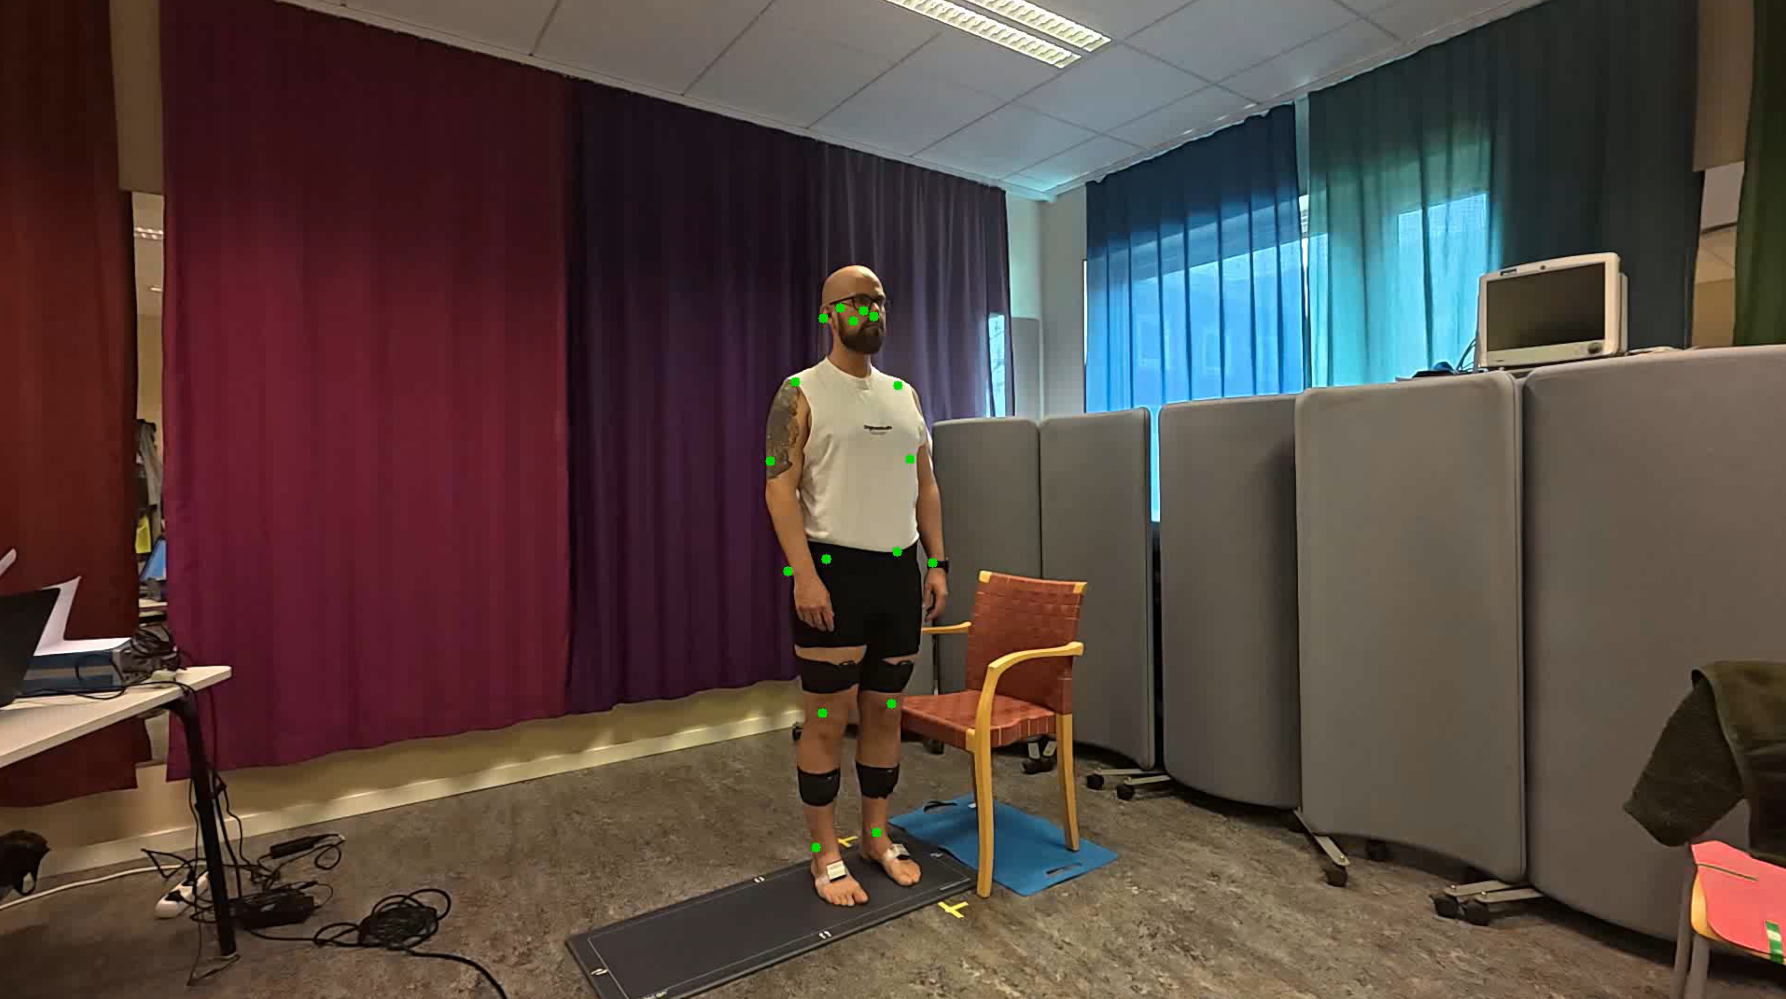

### Retrieving data from first frame

In [21]:
import pandas as pd
from pathlib import Path

CSV_DIR = Path('../data/original/Keypoints 8.5.2025/Fp3')
FIRST_CSV = 'DJI_20250425111640_0056_D.csv'
FIRST_CSV_PATH = CSV_DIR / FIRST_CSV

df = pd.read_csv(FIRST_CSV_PATH)
first_frame = df[df['frame'] == 0]
first_frame

,frame,keypoint_index,y,x,confidence
0,0,0,0.478044,0.401832,0.589204
1,0,1,0.483643,0.395965,0.481633
2,0,2,0.470830,0.394526,0.508714
3,0,3,0.489333,0.399332,0.559134
4,0,4,0.461034,0.400377,0.688463
5,0,5,0.502642,0.437867,0.405844
6,0,6,0.445404,0.435504,0.494687
7,0,7,0.509569,0.478792,0.497540
8,0,8,0.431769,0.480101,0.397301
9,0,9,0.522264,0.536904,0.489843


### Plotting the points

First we plot the points to try to match the layout in the screenshot

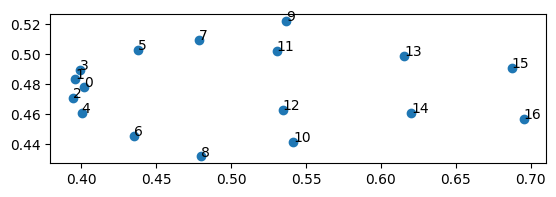

In [22]:
import matplotlib.pyplot as plt

plt.scatter(first_frame['x'], first_frame['y'])
ax = plt.gca()
ax.set_aspect('equal')

for i, key_idx in enumerate(first_frame['keypoint_index']):
    plt.annotate(key_idx, (first_frame['x'][i], first_frame['y'][i]))

plt.show()

The points corresponding to the head are now positioned to the left. This suggets the x- and y columns in the csv are flipped. We try swapping them

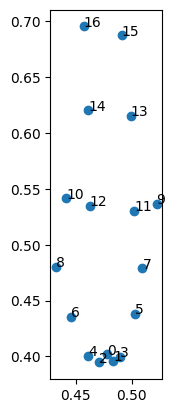

In [23]:
plt.scatter(first_frame['y'], first_frame['x'])
ax = plt.gca()
ax.set_aspect('equal')

for i, key_idx in enumerate(first_frame['keypoint_index']):
    plt.annotate(key_idx, (first_frame['y'][i], first_frame['x'][i]))

plt.show()

Now it appears upside down. This likely means the origin (0,0) is at the top left of the screen. So we invert the y axis in the plot

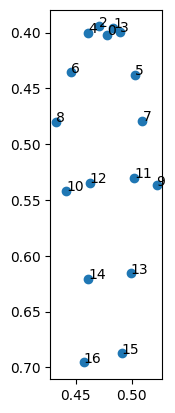

In [24]:
plt.scatter(first_frame['y'], first_frame['x'])
ax = plt.gca()
ax.invert_yaxis()
ax.set_aspect('equal')

for i, key_idx in enumerate(first_frame['keypoint_index']):
    plt.annotate(key_idx, (first_frame['y'][i], first_frame['x'][i]))

plt.show()

This now matches the first frame of the video. You can tell that the left ankle (from the person's perspective) is slightly higher up than the right, just like in the video due to the camera angle.

From this, we can map the keypoint indices to the person's joints. Here, left/right refers to the person's perspective rather than the camera:

| keypoint_index | joint |
| -------------- | ----- |
| 0-4 | head |
| 5 | left shoulder |
| 6 | right shoulder |
| 7 | left elbow |
| 8 | right elbow |
| 9 | left wrist |
| 10 | right wrist |
| 11 | left hip |
| 12 | right hip |
| 13 | left knee |
| 14 | right knee |
| 15 | left ankle |
| 16 | right ankle |

## 2. Reformatting

Next, we reformat the csv files the following way:
* Each row inclues the frame number along with the x, y and confidence of each joint
    * the columns would then become: `frame, left_shoulder_x, left_shoulder_y, left_shoulder_confidence, right_shoulder_x, ...`
* The key points belonging to the head (keypoint_index 0-4) are excluded
* Due to the x and y columns being swapped in the original dataset, the new dataset will use the opposite column naming to correct for this
* This results in 12 * 3 + 1 = 37 columns total

In [25]:
keypoint_to_joint = {
    5: 'left_shoulder',
    6: 'right_shoulder',
    7: 'left_elbow',
    8: 'right_elbow',
    9: 'left_wrist',
    10: 'right_wrist',
    11: 'left_hip',
    12: 'right_hip',
    13: 'left_knee',
    14: 'right_knee',
    15: 'left_ankle',
    16: 'right_ankle'
}


def reformat_file(input_file_path, output_dir, output_file_name, swap_x_y = True):
    df = pd.read_csv(Path(input_file_path))

    if swap_x_y:
        df = df.rename(columns={'x': 'y', 'y': 'x'})
    
    df = df[df['keypoint_index'].isin(keypoint_to_joint.keys())]

    df["joint"] = df["keypoint_index"].map(keypoint_to_joint)
    wide_df = (df.pivot(index="frame", columns="joint", values=["x", "y", "confidence"]))

    wide_df.columns = [f"{joint}_{coord}" for coord, joint in wide_df.columns]
    wide_df.reset_index(inplace=True)

    sorted_column_order = ['frame'] + [f'{joint}_{coord}' for joint in keypoint_to_joint.values() for coord in ['x', 'y', 'confidence']]
    sorted_wide_df = wide_df[sorted_column_order]

    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    sorted_wide_df.to_csv(output_dir / output_file_name, sep=',', index=False)
    print(f'{output_file_name} saved to {output_dir}')

### Generating the files

Our focus is on the sit-to-stand movement, which includes five different variations 2a-2e. After inspecting the videos, the files ending with 0057 to 0061 correspond to these five movements. The current data only includes one participant, fp3. Therefore, we will only select the five relevant files for reformatting and name them according to their movement type and participant.

In [26]:
INPUT_DIR = '../data/original/Keypoints 8.5.2025/Fp3'
OUTPUT_DIR = '../data/processed/keypoints'

recording_to_movement_id = {
    'DJI_20250425111854_0057_D.csv': '2a',
    'DJI_20250425112255_0058_D.csv': '2b',
    'DJI_20250425112502_0059_D.csv': '2c',
    'DJI_20250425112635_0060_D.csv': '2d',
    'DJI_20250425112749_0061_D.csv': '2e'
}
person_id = 'fp3'

for file_name in recording_to_movement_id.keys():
    input_file_path = Path(INPUT_DIR) / Path(file_name)
    output_file_name = f'{person_id}_{recording_to_movement_id[file_name]}.csv'
    reformat_file(input_file_path, OUTPUT_DIR, output_file_name)

fp3_2a.csv saved to ../data/processed/keypoints
fp3_2b.csv saved to ../data/processed/keypoints
fp3_2c.csv saved to ../data/processed/keypoints
fp3_2d.csv saved to ../data/processed/keypoints
fp3_2e.csv saved to ../data/processed/keypoints


## 3. Adding features

Next, we create new features based on the existing ones.

### 3.1 Angles

First we use the joint positions to derive their angles. Based on the available joints, we compute the following angles:
* Elbow (between elbow-wrist and elbow-shoulder)
* Hip (between hip-shoulder and hip-knee)
* Knee (between knee-ankle and knee-hip)

Each angle is computed separately on both the left and right side of the body, for a total of six new features.

In [27]:
import numpy as np

def compute_angle(joint_a_x, joint_a_y, joint_b_x, joint_b_y, joint_c_x, joint_c_y):
    joint_a = np.column_stack([joint_a_x, joint_a_y])
    joint_b = np.column_stack([joint_b_x, joint_b_y])
    joint_c = np.column_stack([joint_c_x, joint_c_y])

    limb_1 = joint_a - joint_b
    limb_2 = joint_c - joint_b

    limb_1_unit = limb_1 / np.linalg.norm(limb_1, axis=1)[:, None]
    limb_2_unit = limb_2 / np.linalg.norm(limb_2, axis=1)[:, None]

    cos_angle = np.einsum('ij,ij->i', limb_1_unit, limb_2_unit)
    cos_angle = np.clip(cos_angle, -1.0, 1.0)
    angle = np.arccos(cos_angle)
    return angle


def add_angle_features(input_path, output_path=None):
    input_path = Path(input_path)
    df = pd.read_csv(input_path)

    left_elbow_angle = compute_angle(
        df['left_wrist_x'], df['left_wrist_y'],
        df['left_elbow_x'], df['left_elbow_y'],
        df['left_shoulder_x'], df['left_shoulder_y']
    )
    df.insert(df.columns.get_loc('left_elbow_confidence') + 1, 'left_elbow_angle', left_elbow_angle)

    right_elbow_angle = compute_angle(
        df['right_wrist_x'], df['right_wrist_y'],
        df['right_elbow_x'], df['right_elbow_y'],
        df['right_shoulder_x'], df['right_shoulder_y']
    )
    df.insert(df.columns.get_loc('right_elbow_confidence') + 1, 'right_elbow_angle', right_elbow_angle)

    left_hip_angle = compute_angle(
        df['left_shoulder_x'], df['left_shoulder_y'],
        df['left_hip_x'], df['left_hip_y'],
        df['left_knee_x'], df['left_knee_y']
    )
    df.insert(df.columns.get_loc('left_hip_confidence') + 1, 'left_hip_angle', left_hip_angle)

    right_hip_angle = compute_angle(
        df['right_shoulder_x'], df['right_shoulder_y'],
        df['right_hip_x'], df['right_hip_y'],
        df['right_knee_x'], df['right_knee_y']
    )
    df.insert(df.columns.get_loc('right_hip_confidence') + 1, 'right_hip_angle', right_hip_angle)

    left_knee_angle = compute_angle(
        df['left_ankle_x'], df['left_ankle_y'],
        df['left_knee_x'], df['left_knee_y'],
        df['left_hip_x'], df['left_hip_y']
    )
    df.insert(df.columns.get_loc('left_knee_confidence') + 1, 'left_knee_angle', left_knee_angle)

    right_knee_angle = compute_angle(
        df['right_ankle_x'], df['right_ankle_y'],
        df['right_knee_x'], df['right_knee_y'],
        df['right_hip_x'], df['right_hip_y']
    )
    df.insert(df.columns.get_loc('right_knee_confidence') + 1, 'right_knee_angle', right_knee_angle)

    if output_path is None:
        output_path = input_path.with_name(input_path.stem + '_angles.csv')
    else:
        output_path = Path(output_path)
        output_path.parent.mkdir(parents=True, exist_ok=True)

    df.to_csv(output_path, index=False)
    print(f'{output_path.name} saved to {output_path}')


def add_angles_to_dir(input_dir, output_dir=None):
    input_dir = Path(input_dir)
    for file in input_dir.rglob('*.csv'):
        if file.name.endswith('_angles.csv'):
            continue
        if output_dir is None:
            add_angle_features(file)
        else:
            output_path = Path(output_dir) / (file.stem + '_angles.csv')
            add_angle_features(file, output_path)

In [28]:
INPUT_DIR = '../data/processed/keypoints'
OUTPUT_DIR = '../data/processed/keypoints/angles'

add_angles_to_dir(INPUT_DIR, OUTPUT_DIR)

fp3_2a_angles.csv saved to ../data/processed/keypoints/angles/fp3_2a_angles.csv
fp3_2b_angles.csv saved to ../data/processed/keypoints/angles/fp3_2b_angles.csv
fp3_2c_angles.csv saved to ../data/processed/keypoints/angles/fp3_2c_angles.csv
fp3_2d_angles.csv saved to ../data/processed/keypoints/angles/fp3_2d_angles.csv
fp3_2e_angles.csv saved to ../data/processed/keypoints/angles/fp3_2e_angles.csv
